# Домашнее задание
## Автокодировщики и автокодирование

## Цель:
Разберемся с тем, как работает автокодировщик и что содержится в латентном представлении данных.


## Описание/Пошаговая инструкция выполнения домашнего задания:
### Обучить многослойный автокодировщик:
- а. отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем
- б. сделать tSNE над 32-мерным латентным слоем, отрисовать представление
### Обучить шумный автокодировщик:
- а. Добавить ко входным данным нормальный шум
- б. Сделать отражение части изображения
- в. Отрисовать карты активаций нейронов первого слоя

In [1]:
#импорт модулей
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.datasets import MNIST
import torchvision.transforms as tfs

from sklearn.manifold import TSNE

import random
import os
import tqdm

%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#Зафиксирую seed для воспроизводимости
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    

In [3]:
seed =  42
seed_everything(seed)

In [4]:
N_ep = 5 #эпохи 'почему-то больше 5 эпох убивают ядро на tsne'

In [5]:
df_img_tfs = tfs.Compose([tfs.ToTensor(), tfs.Normalize((0.5), (0.5))])

#В модуле torchvision.transforms as tfs определить преобразование Compose, 
#которое будет преобразовывать изображение в тензор и нормализовать его значениями среднего и стандартного отклонения. 
#Для этого использовать два преобразования: ToTensor(), 
#которое преобразует изображение в тензор, и Normalize(), которое нормализует значения тензора. 
#Передать в Normalize() среднее значение и стандартное отклонение, которые будут использоваться для нормализации.

In [6]:
# Установка train and test
path = './'
train = MNIST(path, train=True,  transform=df_img_tfs, download=True)
test  = MNIST(path, train=False, transform=df_img_tfs, download=True)

#Использовать библиотеку PyTorch для загрузки набора данных MNIST, 
#который содержит изображения рукописных цифр. 
#Здесь path - это корневая директория, в которой будут храниться данные. 
#При загрузке данных указываем, что мы загружаем тренировочный набор (train=True) и тестовый набор (train=False).
#Также мы используем transform=df_img_tfs, чтобы преобразовать данные в формат, 
#который может быть использован для обучения модели. 
#В данном случае мы используем df_img_tfs, что представляет собой объект трансформации, определенный ранее в коде.
#Наконец, мы используем download=True, чтобы автоматически загрузить данные, если они еще не были загружены.

In [7]:
# Устанвока batch_size, train_loader, test_loader
batch_size = 256

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [8]:
# Устанвока device == cpu or cuda?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Обучить многослойный автокодировщик:

### определяю две модели нейронных сетей: Encoder и Decoder, которые используются для автоэнкодера.
Обе модели являются наследниками класса nn.Module и используются вместе для создания автоэнкодера.

Encoder - это модель, которая принимает на вход изображение размером 28x28 пикселей (которое было преобразовано в вектор размером 784 пикселя) и преобразует его в вектор низкой размерности (latent_size), который представляет собой сжатое представление изображения. В этом коде latent_size равен 10. Модель содержит один линейный слой nn.Linear(28*28, latent_size), который преобразует входной вектор размером 784 в выходной вектор размером 10. Затем применяю сигмоидную функцию активации torch.sigmoid, чтобы получить значения между 0 и 1.

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

Decoder - это модель, которая принимает на вход вектор низкой размерности (latent_size) и преобразует его обратно в изображение размером 28x28 пикселей. В этом коде latent_size также равен 10. Модель содержит один линейный слой nn.Linear(latent_size, 28*28), который преобразует входной вектор размером 10 в выходной вектор размером 784. Затем применяю гиперболический тангенс torch.tanh, чтобы получить значения между -1 и 1.

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

определяю класса Net, который наследуется от класса nn.Module. Внутри класса определены следующие методы:

__init__(self, latent_size=10): конструктор класса, который принимает на вход размерность скрытого пространства latent_size, равную 10 по умолчанию. Внутри метода создаются объекты Encoder и Decoder с передачей значения latent_size.

forward(self, x): метод, который принимает на вход тензор x и выполняет прямой проход нейронной сети. Вначале тензор x преобразуется в двумерный тензор размерности (-1, 28*28), где -1 означает, что размерность будет вычислена автоматически на основе размерности входного тензора. Далее, преобразованный тензор x пропускается через Encoder, который возвращает скрытое представление hidden. Затем, скрытое представление hidden передается в Decoder, который возвращает выходной тензор out.

decode(self, hidden): метод, который принимает на вход скрытое представление hidden и возвращает декодированный тензор, полученный с помощью Decoder.

Описание, что данный класс является реализацией нейронной сети автоэнкодер, который принимает на вход изображение размерности 28x28 пикселей и пытается восстановить его с помощью сжатого представления в скрытом пространстве размерности latent_size. Метод forward выполняет прямой проход нейронной сети, а метод decode возвращает декодированный тензор на основе заданного скрытого представления.

In [11]:
class Net(nn.Module):
    def __init__(self, latent_size=10):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        hidden = self.E(x)
        out = self.D(hidden)
        return out
    
    def decode(self, hidden):
        with torch.no_grad():
            return self.D(hidden)

In [12]:
# Создаю модель
model = Net(2) #в задании "с двумерным латентным слоем"

часть процесса обучения нейронной сети: функция потерь nn.CrossEntropyLoss() используется для оценки разницы между выходом нейронной сети и правильными ответами на обучающих данных. Оптимизатор torch.optim.Adam() используется для обновления весов нейронной сети в процессе обучения с целью минимизации функции потерь. Скорость обучения lr задает, насколько быстро будет проходить процесс обучения.

функция потерь criterion типа nn.CrossEntropyLoss(), которая будет использоваться в процессе обучения нейронной сети.

In [13]:
criterion = nn.CrossEntropyLoss() # функция потерь

оптимизатор optimizer типа torch.optim.Adam(), который будет использоваться для обновления весов нейронной сети в процессе обучения. Оптимизатор принимает на вход параметры модели model с помощью метода model.parameters(), а также задает скорость обучения lr, равную 1e-4.

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # оптимизатор

Реализую процесс обучения нейронной сети на данных для обучения train_loader. Для каждой эпохи обучения вычисляется среднее значение функции потерь на данных для обучения и тестирования, которое добавляется в соответствующие списки. Это позволяет отслеживать процесс обучения и оценивать качество работы нейронной сети на данных для тестирования.

Цикл обучения нейронной сети на данных для обучения train_loader и вычисляет значение функции потерь на данных для тестирования test_loader. 

Цикл проходит N_ep эпох обучения, каждая из которых состоит из нескольких итераций, где каждая итерация загружает батч данных x_batch и соответствующие метки y_batch из train_loader. 

Далее выполняются следующие шаги:

1. Преобразование x_batch в двумерный тензор (-1, 784) и перенос на устройство device.
2. Вычисление предсказаний нейронной сети для x_batch.
3. Вычисление функции потерь loss с помощью критерия criterion и предсказаний preds.
4. Обнуление градиентов в оптимизаторе optimizer.
5. Вычисление градиентов функции потерь loss с помощью метода backward().
6. Шаг оптимизатора optimizer для обновления весов нейронной сети.

Значения функции потерь для каждого батча данных history_train и history_test добавляются в соответствующие списки. После окончания каждой эпохи вычисляется среднее значение функции потерь для всех батчей данных, и эти значения добавляются в списки losses_train и losses_test.

In [15]:
losses_train = [] #список losses_train
losses_test = [] #список losses_test
N_ep = N_ep
for epoch in tqdm.tqdm(range(N_ep)):
    history_train = []
    history_test = []
    for x_batch, y_batch in train_loader:
    # 1. # загружаю батч данных
        x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
        y_batch = y_batch.to(device)

    # 2. вычисляю предсказние для x_batch
        preds = model(x_batch)

    # 3. вычисляю - функцию потерь (loss)
        loss = criterion(preds, y_batch)

    # 4. вычисляю градиенты
        optimizer.zero_grad()
        loss.backward()

    # 5. шаг градиентного спуска
        optimizer.step()
        history_train.append(loss.item())
    
    losses_train.append(np.mean(history_train))
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
            y_batch = y_batch.to(device)
            
            preds = model(x_batch)
            
            loss = criterion(preds, y_batch)
            
            history_test.append(loss.item())
    
    losses_test.append(np.mean(history_test))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


<Axes: >

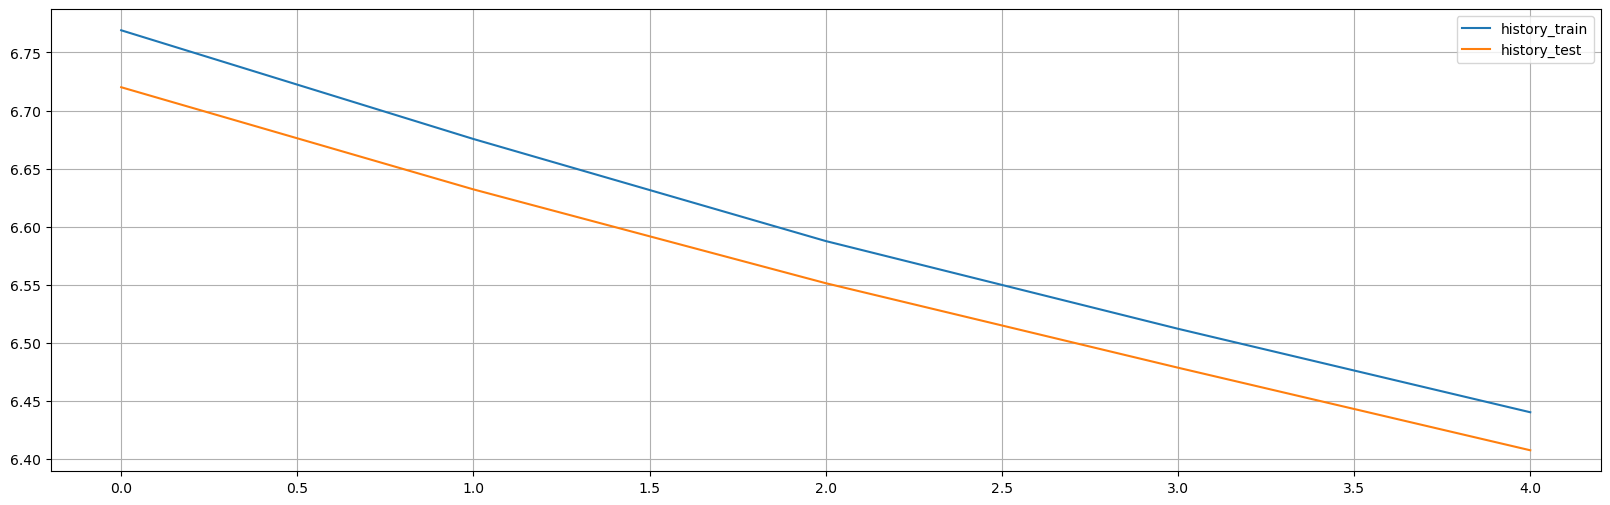

In [16]:
# отрисую обучение
df = pd.DataFrame({'history_train': losses_train, 'history_test': losses_test})
df.plot(figsize = (20,6), grid = True)

## а. отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем

загружаю данные для тестирования нейронной сети из test_loader и привожу их к типу float. 
Первый элемент batch, batch[0], содержит данные, а второй элемент batch[1] содержит целевые значения. 
загружаю данные для тестирования нейронной сети и приводит их к нужному типу данных.

In [17]:
for batch in test_loader:
    data = batch[0].float()
    lable = batch[1].float()   

In [18]:
data = data.view(-1,28*28)
data

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

In [19]:
lable = lable.detach().cpu().numpy().astype(int).astype(str)
lable

array(['4', '5', '6', '7', '8', '9', '7', '4', '6', '1', '4', '0', '9',
       '9', '3', '7', '8', '4', '7', '5', '8', '5', '3', '2', '2', '0',
       '5', '8', '6', '0', '3', '8', '1', '0', '3', '0', '4', '7', '4',
       '9', '2', '9', '5', '7', '1', '7', '1', '6', '6', '5', '6', '2',
       '8', '7', '6', '4', '9', '9', '5', '3', '7', '4', '3', '0', '4',
       '6', '6', '1', '1', '3', '2', '1', '0', '0', '1', '2', '3', '4',
       '7', '8', '9', '0', '1', '2', '3', '4', '5', '6', '7', '8', '0',
       '1', '2', '3', '4', '7', '8', '9', '0', '8', '3', '9', '5', '5',
       '2', '6', '8', '4', '1', '7', '1', '2', '3', '5', '6', '9', '1',
       '1', '1', '2', '1', '2', '0', '7', '7', '5', '8', '2', '9', '8',
       '6', '7', '3', '4', '6', '8', '7', '0', '4', '2', '7', '7', '5',
       '4', '3', '4', '2', '8', '1', '5', '1', '0', '2', '3', '3', '5',
       '7', '0', '6', '8', '6', '3', '9', '9', '8', '2', '7', '7', '1',
       '0', '1', '7', '8', '9', '0', '1', '2', '3', '4', '5', '6

In [20]:
simple_model = model.E(data)
simple_model = simple_model.detach().numpy()
simple_model

array([[1.6546327e-03, 9.4910997e-01],
       [1.4553692e-03, 9.6353763e-01],
       [2.7972441e-03, 9.9183160e-01],
       [4.4249883e-03, 9.7917694e-01],
       [3.2122326e-03, 9.4491982e-01],
       [2.3616652e-03, 9.7182459e-01],
       [3.4958441e-03, 9.9939549e-01],
       [1.3074154e-03, 7.8095108e-01],
       [3.4995584e-03, 9.9687922e-01],
       [1.4040231e-03, 7.7814370e-02],
       [2.3050583e-03, 9.6737695e-01],
       [5.3694881e-03, 9.9507773e-01],
       [4.6371911e-03, 9.9136621e-01],
       [3.1990726e-03, 9.8081332e-01],
       [1.5875970e-03, 9.8860860e-01],
       [2.3659822e-03, 9.3460852e-01],
       [2.0690332e-03, 2.0392729e-01],
       [3.3036640e-03, 9.6500999e-01],
       [3.5258988e-03, 9.9822181e-01],
       [1.4107346e-03, 9.5561010e-01],
       [2.5634300e-03, 8.6633307e-01],
       [2.7771376e-03, 9.8988718e-01],
       [2.2775398e-03, 9.9805862e-01],
       [6.8332558e-03, 9.9825841e-01],
       [7.6331929e-03, 9.9308783e-01],
       [3.8865712e-03, 9.

C:\Users\smndy\anaconda3\lib\site-packages\seaborn\_oldcore.py:917: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


<Axes: >

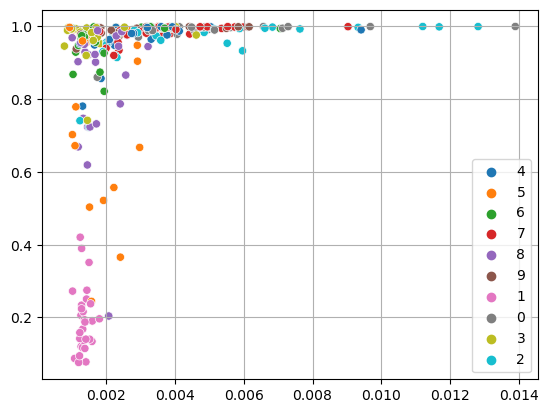

In [21]:
#отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем
ax = sns.scatterplot(data=simple_model, x=simple_model[:,0], y=simple_model[:,-1], hue=lable)
ax.grid()

ax

## б. сделать tSNE над 32-мерным латентным слоем, отрисовать представление

In [22]:
# Создаю модель
model_32 = Net(32) #в задании "над 32-мерным латентным слоем"

In [23]:
optimizer_32 = torch.optim.Adam(model_32.parameters(), lr=1e-4) # оптимизатор

In [24]:
losses_train = [] #список losses_train
losses_test = [] #список losses_test

for epoch in tqdm.tqdm(range(N_ep)):
    history_train = []
    history_test = []
    for x_batch, y_batch in train_loader:
    # 1. # загружаю батч данных
        x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
        y_batch = y_batch.to(device)

    # 2. вычисляю предсказние для x_batch
        preds = model_32(x_batch)

    # 3. вычисляю - функцию потерь (loss)
        loss = criterion(preds, y_batch)

    # 4. вычисляю градиенты
        optimizer.zero_grad()
        loss.backward()

    # 5. шаг градиентного спуска
        optimizer_32.step()
        history_train.append(loss.item())
    
    losses_train.append(np.mean(history_train))
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
            y_batch = y_batch.to(device)
            
            preds = model_32(x_batch)
            
            loss = criterion(preds, y_batch)
            
            history_test.append(loss.item())
    
    losses_test.append(np.mean(history_test))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.93s/it]


<Axes: >

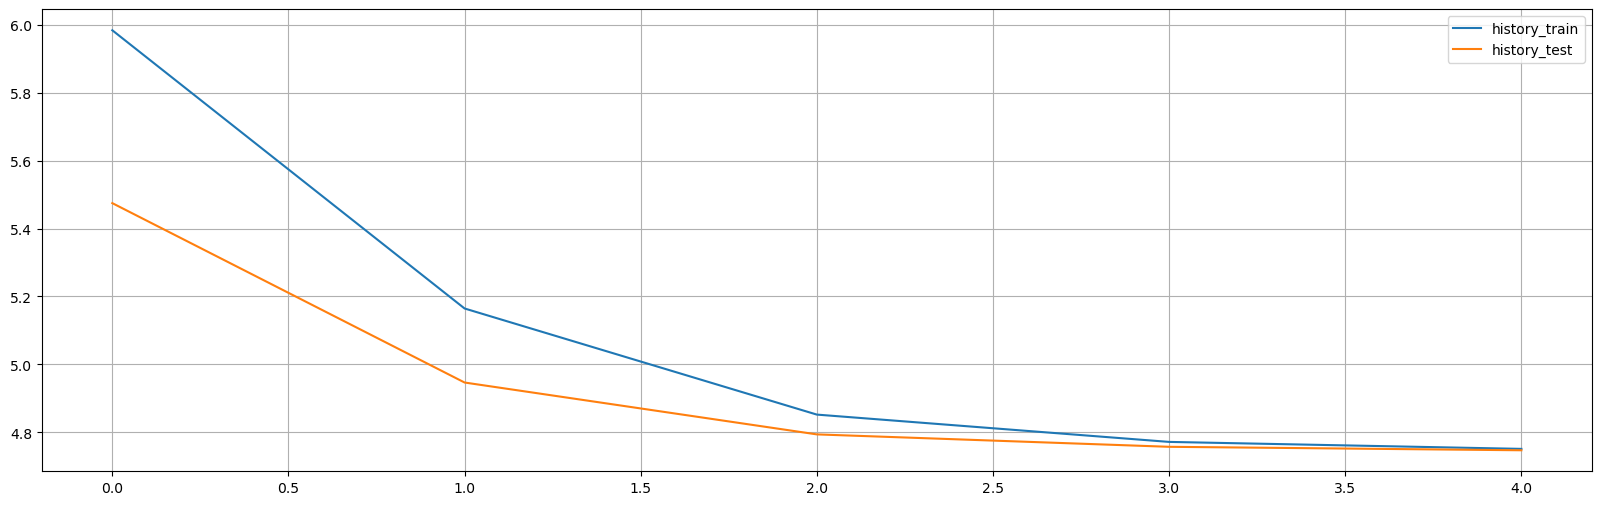

In [25]:
# отрисую обучение
df_32 = pd.DataFrame({'history_train': losses_train, 'history_test': losses_test})
df_32.plot(figsize = (20,6), grid = True)

### tSNE над 32-мерным латентным слоем, отрисовать представление

In [26]:
for batch in test_loader:
    data_32 = batch[0].float()
    lable = batch[1].float()

In [27]:
data_32 = data_32.view(-1,28*28)

In [28]:
simple_model_32 = model_32.E(data_32)
simple_model_32 = simple_model_32.detach().numpy()

In [29]:
simple_model_32.shape

(256, 32)

In [30]:
tsne = TSNE(n_components=2, random_state = seed)

In [31]:
simple_model_32

array([[3.5606114e-29, 4.8090394e-19, 1.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [1.0493797e-29, 2.6927740e-19, 1.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [2.2521570e-25, 5.5569745e-22, 1.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       ...,
       [9.1787256e-30, 3.4734012e-19, 1.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [9.0542673e-29, 5.8807708e-20, 1.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [5.8416672e-27, 2.8490110e-27, 1.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00]], dtype=float32)

In [32]:
X_tsne = tsne.fit_transform(simple_model_32)

In [33]:
lable = lable.detach().cpu().numpy().astype(int).astype(str)
lable

array(['4', '5', '6', '7', '8', '9', '7', '4', '6', '1', '4', '0', '9',
       '9', '3', '7', '8', '4', '7', '5', '8', '5', '3', '2', '2', '0',
       '5', '8', '6', '0', '3', '8', '1', '0', '3', '0', '4', '7', '4',
       '9', '2', '9', '5', '7', '1', '7', '1', '6', '6', '5', '6', '2',
       '8', '7', '6', '4', '9', '9', '5', '3', '7', '4', '3', '0', '4',
       '6', '6', '1', '1', '3', '2', '1', '0', '0', '1', '2', '3', '4',
       '7', '8', '9', '0', '1', '2', '3', '4', '5', '6', '7', '8', '0',
       '1', '2', '3', '4', '7', '8', '9', '0', '8', '3', '9', '5', '5',
       '2', '6', '8', '4', '1', '7', '1', '2', '3', '5', '6', '9', '1',
       '1', '1', '2', '1', '2', '0', '7', '7', '5', '8', '2', '9', '8',
       '6', '7', '3', '4', '6', '8', '7', '0', '4', '2', '7', '7', '5',
       '4', '3', '4', '2', '8', '1', '5', '1', '0', '2', '3', '3', '5',
       '7', '0', '6', '8', '6', '3', '9', '9', '8', '2', '7', '7', '1',
       '0', '1', '7', '8', '9', '0', '1', '2', '3', '4', '5', '6

In [34]:
df_tnse = pd.DataFrame({'lable': lable, 'X': X_tsne[:,0], 'Y': X_tsne[:,-1]})

<Axes: xlabel='X', ylabel='Y'>

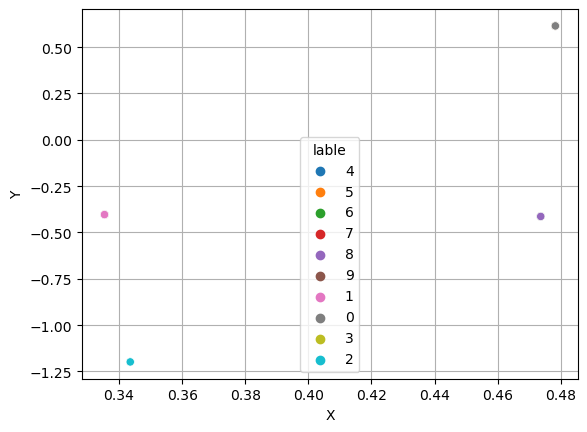

In [35]:
#отрисовать представление
ax_32 = sns.scatterplot(data=df_tnse, x='X', y='Y', hue='lable')
ax_32.grid()

ax_32

In [36]:
df_tnse

,lable,X,Y
0,4,0.335437,-0.403478
1,5,0.335415,-0.403489
2,6,0.473633,-0.413476
3,7,0.473633,-0.413476
4,8,0.473636,-0.413478
...,...,...,...
251,7,0.478276,0.614535
252,2,0.478276,0.614535
253,6,0.478276,0.614535
254,5,0.478276,0.614535


#### У меня получилось, что на большем числе эпох "умирает ядро"

## Обучить шумный автокодировщик:
- а. Добавить ко входным данным нормальный шум
- б. Сделать отражение части изображения
- в. Отрисовать карты активаций нейронов первого слоя

готовлю модель Encoder, Decoder, Net

In [37]:
class Encoder(nn.Module):
    def __init__(self, latent_size=64):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=64):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [38]:
class Net(nn.Module):
    def __init__(self, latent_size=64, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x) #hidden
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [39]:
models = {'16': Net(16), '32': Net(32)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [40]:
for batch in test_loader:
    data_n = batch[0].float()
    lable = batch[1].float()

In [41]:
data_n = data_n.view(-1,28*28)

In [42]:
data_n.shape

torch.Size([256, 784])

### а. Добавить ко входным данным нормальный шум

Cоздаю массив случайных значений с нормальным распределением и добавляет его к PyTorch тензору data_n для добавления шума к данным, затем отражает полученный тензор по горизонтали.

Массив случайных значений с нормальным распределением с параметрами mu и sigma и размером [256,784], используя функцию np.random.normal(). Затем этот массив добавляется к data_n, который является PyTorch тензором, чтобы добавить шум к данным. Затем data_noise отражается по горизонтали с помощью функции torch.fliplr(). 

In [43]:
mu = 0
sigma = 0.1
noise = np.random.normal(mu, sigma, [256,784])
data_noise = data_n + noise
data_noise = torch.fliplr(data_noise)

In [44]:
data_n = [el.reshape(28,28) for el in data_n]

In [45]:
data_n[:1]

[tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1

In [46]:
data_noise = [el.reshape(28,28) for el in data_noise]
data_noise[:1]

[tensor([[-0.9389, -0.9620, -1.1335, -0.9822, -0.9379, -1.0074, -1.0248, -1.0727,
          -1.1570, -0.9378, -0.9027, -0.9368, -1.0562, -0.9292, -0.8188, -1.0627,
          -0.8229, -1.0035, -1.0703, -0.8851, -1.0096, -0.7440, -0.9878, -1.0576,
          -0.9300, -1.0858, -0.9815, -0.9507],
         [-0.7368, -1.0949, -0.8946, -1.0976, -1.1352, -1.0923, -1.1407, -1.0612,
          -1.0755, -0.9813, -1.0726, -0.9482, -0.9974, -1.0625, -1.1280, -1.1841,
          -0.8986, -0.8335, -0.9017, -0.9744, -0.9527, -0.8971, -1.1703, -0.9592,
          -1.0978, -0.9804, -1.0778, -1.0540],
         [-0.9652, -0.9982, -1.0184, -0.9829, -0.9257, -1.1348, -1.1710, -0.9692,
          -1.0057, -1.0364, -0.9850, -0.9886, -0.8897, -1.0038, -0.9601, -1.0545,
          -1.0097, -0.9789, -0.8304, -1.2082, -0.8245, -1.1280, -0.9394, -1.1557,
          -1.1408, -1.0704, -0.8951, -1.0523],
         [-1.0185, -0.9076, -1.1251, -0.9674, -1.0310, -0.9407, -0.9384, -1.1081,
          -0.8841, -1.0361, -0.9556, -0

### б. Сделать отражение части изображения

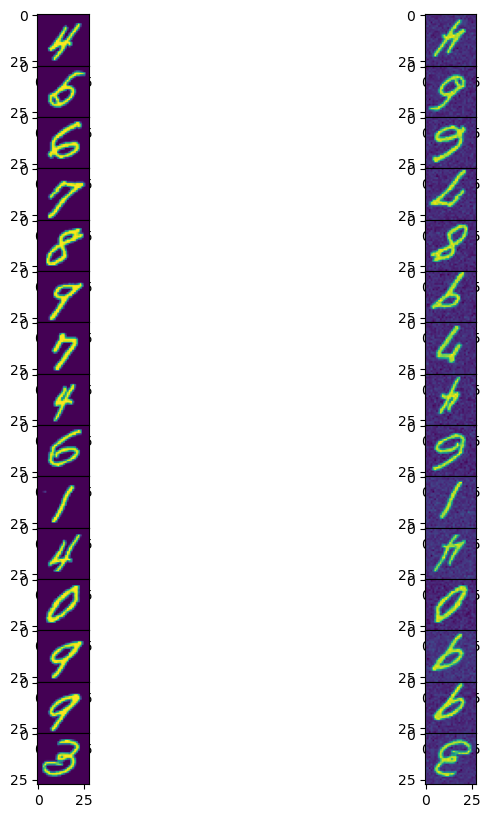

In [47]:
party = 15
fig, axs = plt.subplots(nrows = party, ncols = 2, figsize=(10, 10))

for ind_img in range(party):
    axs[ind_img, 0].imshow(data_n[ind_img])
    axs[ind_img, 1].imshow(data_noise[ind_img])
    
plt.subplots_adjust(wspace=0, hspace=0)

### в. Отрисовать карты активаций нейронов первого слоя

Функция добавление шума к тензору x в зависимости от выбранного режима mode. Если mode равен 'gaussian', то для каждого элемента тензора добавляется случайное значение с нормальным распределением, а если mode равен 'mirror', то тензор отражается по горизонтали.

Добавляет шум к тензору x в зависимости от выбранного режима mode. Если mode равен 'gaussian', то для каждого элемента тензора добавляется случайное значение с нормальным распределением с математическим ожиданием равным 0 и стандартным отклонением равным 0.1, умноженным на корень из 2. Если mode равен 'mirror', то тензор отражается по горизонтали с помощью функции torch.fliplr(). Если случайное число, сгенерированное функцией np.random.randint(2), равно 1, то функция возвращает тензор без изменений. В комментариях на русском языке можно описать, что данный код 

In [48]:
def add_noise(x, mode='gaussian', elementwise=True):
    if np.random.randint(2):
        return x
    x = x.clone()
    if elementwise:
        if mode == 'gaussian':
            for i in range(x.shape[0]):
                x=x+(0.1*np.sqrt(2))*torch.randn(256, 1, 28,28) #x=x+(0.1**0.5)*torch.randn(256, 1, 28,28)
    else:
        if mode == 'mirror':
            x=torch.fliplr(x)
    return x

Функция обучения набора моделей на данных, используя метод обратного распространения ошибки. Для каждой модели вычисляется значение функции потерь на каждой итерации обучения, и выводится информация о ходе обучения.

Обучает набор моделей на данных, используя метод обратного распространения ошибки. В каждой эпохе обучения для каждой модели оптимизируется функция потерь с помощью метода стохастического градиентного спуска. Для каждой модели вычисляется значение функции потерь на каждой итерации обучения. Если значение batch_idx кратно N_print=120, то выводится информация о ходе обучения, включая номер эпохи, номер текущей итерации, общее количество итераций, а также значения функции потерь для каждой модели. Если же batch_idx не кратно N_print=120, то выводится информация о ходе обучения только для последней итерации. Если задан параметр log, то значение функции потерь для каждой модели записывается в соответствующий лог.

In [49]:
def train(epoch, models, log=None, N_print=120):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noised = add_noise(data)
        for model in models.values():
            model.optim.zero_grad()
            output = model(noised)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % N_print == 0:
            line = 'Train Epoch: {} [{:03d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:03d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

Функция тестирования набора моделей на тестовых данных и выводит информацию о значениях функции потерь для каждой модели.

Тестирует набор моделей на тестовых данных и выводит информацию о значениях функции потерь для каждой модели. Для каждой модели вычисляется значение функции потерь на тестовых данных, используя функцию loss() модели. Если случайное число, сгенерированное функцией np.random.randint(2), равно 1, то для добавления шума к данным используется режим 'gaussian', иначе - режим 'mirror'. Значения функции потерь для каждой модели усредняются по всем тестовым данным и выводятся на экран в виде строки. Если задан параметр log, то значение функции потерь для каждой модели записывается в соответствующий лог.

In [50]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            if np.random.randint(2):
                noised = add_noise(data, mode='gaussian')
            else:
                noised = add_noise(data, mode='mirror')
            output = {k: m(noised) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [51]:
for epoch in tqdm.tqdm(range(1, N_ep)):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Train Epoch: 1 [000/60000] 16: 1.0361 32: 1.0068
Train Epoch: 1 [30720/60000] 16: 0.8927 32: 0.7107
Train Epoch: 1 [59904/60000] 16: 0.7761 32: 0.5018


 25%|█████████████████████                                                               | 1/4 [00:54<02:44, 54.72s/it]

Test set:
16: loss: 0.7682
32: loss: 0.4960

Train Epoch: 2 [000/60000] 16: 0.7730 32: 0.4956
Train Epoch: 2 [30720/60000] 16: 0.5653 32: 0.3545
Train Epoch: 2 [59904/60000] 16: 0.4623 32: 0.3179


 50%|██████████████████████████████████████████                                          | 2/4 [01:47<01:47, 53.63s/it]

Test set:
16: loss: 0.4558
32: loss: 0.3138

Train Epoch: 3 [000/60000] 16: 0.4510 32: 0.3080
Train Epoch: 3 [30720/60000] 16: 0.3711 32: 0.2737
Train Epoch: 3 [59904/60000] 16: 0.3509 32: 0.2844


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:39<00:52, 52.75s/it]

Test set:
16: loss: 0.3460
32: loss: 0.2807

Train Epoch: 4 [000/60000] 16: 0.3405 32: 0.2747
Train Epoch: 4 [30720/60000] 16: 0.3068 32: 0.2581
Train Epoch: 4 [59904/60000] 16: 0.3129 32: 0.2741


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:31<00:00, 52.95s/it]

Test set:
16: loss: 0.3085
32: loss: 0.2706



In [52]:
for batch in test_loader:
    data = batch[0].float()
    lable = batch[1].float()

In [53]:
data = [el.reshape(28,28) for el in data]

Загружаю данные из test_loader и использует функцию add_noise, чтобы добавить шум к данным data. Параметр elementwise=True указывает, что шум должен быть добавлен к каждому элементу данных. Затем код использует модель '32', чтобы получить выходные данные для первых N_first = 50 элементов данных после добавления шума. 

In [54]:
N_first = 50

# Загрузка данных из test_loader
data, _ = next(iter(test_loader))

# Добавление шума к данным с помощью функции add_noise
noised = add_noise(data, elementwise=True)

# Получение выходных данных модели '32' для первых 50 элементов данных с добавленным шумом
output = models['32'](noised[:N_first])

In [55]:
plot_map = output.view(-1, 1, 28, 28).data.numpy()

In [56]:
plot_map = [el.reshape(28,28) for el in plot_map]

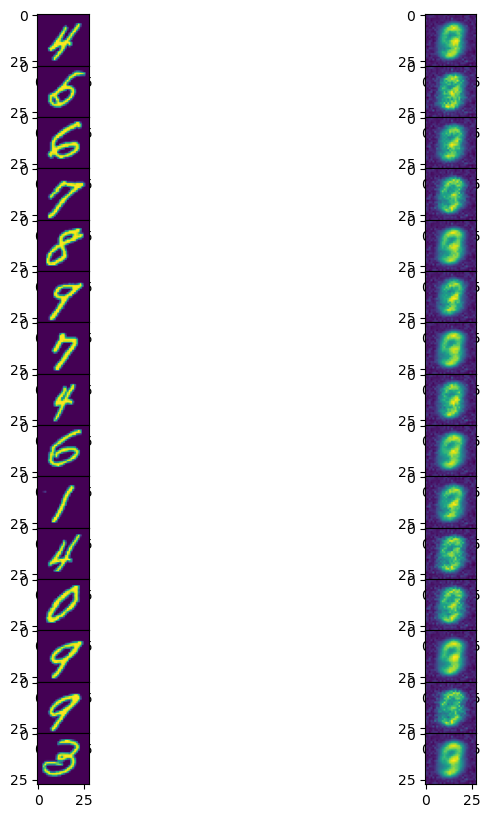

In [57]:
fig, axs = plt.subplots(nrows = party, ncols = 2, figsize=(10, 10))

for ind_img in range(party):
    axs[ind_img, 0].imshow(data_n[ind_img])
    axs[ind_img, 1].imshow(plot_map[ind_img])
    
plt.subplots_adjust(wspace=0, hspace=0)

# Вывод:
## Обучил многослойный автокодировщик:
- а. отрисовал классы в латентном представлении автокодировщика с двумерным латентным слоем
- б. сделать tSNE над 32-мерным латентным слоем, отрисовать представление
- выявил, что при числе эпох больше 5 "умирает ядро"
## Обучил шумный автокодировщик:
- а. Добавил ко входным данным нормальный шум
- б. Сделал отражение части изображения
- в. Отрисовал карты активаций нейронов первого слоя